# GeoPandas Covid Vaccination Map

This notebook was created as a way to practice using and applying Geopandas methods after my completion of a Geopandas micro course on Kaggle. I was inspired by maps [such as this one]( https://www.nbcnews.com/health/health-news/map-covid-19-vaccination-tracker-across-u-s-n1252085) and wanted to try creating something similar using Geopandas. The objective was to clean and prepare some datasets for analysis, convert the necessary data to GeoDataFrame format, and create a choropleth map which would display Covid vaccination rates and distribution rates per state, using the most current data available. For the purpose of this project, I imported 2 initial datasets; one contained detailed records of Covid vaccination data, segmented by state and date (provided by Our World in Data). The other is a csv file containing state population estimates. 

In [1]:
import pandas as pd

state_pop = pd.read_csv('us_state_pop.csv')
state_pop = state_pop.rename(columns={'STATE':'state'})
vaccinations_df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv')

vaccinations_df.head()

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.44,7.69,NaN,NaN,NaN,0.207
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.52,7.73,5906.0,5906.0,1205.0,0.222
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,1.88,NaN,1.64,8.88,8260.0,7083.0,1445.0,0.212
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,0.27,2.05,13488.0,1.77,9.07,8267.0,7478.0,1525.0,0.226
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7557.0,7498.0,1529.0,NaN


Before creating the Geopandas plot, some cleaning of the data was required. I started by using the _datetime_ package to filter the dataframe to contain only the most recently available data for each state. This started with using the _timedelta_ method to subtract one day from the current date, followed by the _strftime_ method to convert the datetime variable to a string which could be used as a filter. After filtering by date, I also used a regex expression to fix New York, since it was listed as 'New York State' and was causing problems with merging dataframes by state name. After merging the __state_pop__ and __recent_vaccines__ dataframes, the final data preparation step was using the population and vaccination figures to create a rough estimate of the percentage of the state population that had been vaccinated.

In [2]:
#vaccinations dataframe cleaning

import datetime
delta = datetime.timedelta(days=-1)
most_recent = datetime.datetime.now() + delta
most_recent_date = most_recent.strftime('%Y-%m-%d')
most_recent_date

recent_vaccines = vaccinations_df[vaccinations_df.date == most_recent_date]
recent_vaccines = recent_vaccines.rename(columns={'location':'state'})
recent_vaccines.state = recent_vaccines['state'].replace('New York State', 'New York', regex=True)
#print(recent_vaccines.state.unique())

#joining dataframes
state_vaccine_data = pd.merge(state_pop, recent_vaccines, on='state')
state_vaccine_data = state_vaccine_data.rename(columns={'POPESTIMATE2019':'pop_estimate'})
state_vaccine_data['percent_vaccinated'] = round(100 * (state_vaccine_data['people_fully_vaccinated'] / state_vaccine_data['pop_estimate']), 2)
state_vaccine_data['percent_rcvd_dose'] = round(100 * (state_vaccine_data['people_vaccinated'] / state_vaccine_data['pop_estimate']), 2)
state_vaccine_data.head()

,state,pop_estimate,lat,long,date,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used,percent_vaccinated,percent_rcvd_dose
0,Alabama,4903185,32.377716,-86.300568,2021-02-22,793614.0,1082100.0,570355.0,4.52,16.19,221785.0,11.63,22.07,5001.0,24164.0,4928.0,0.733,4.52,11.63
1,Alaska,731545,58.301598,-134.420212,2021-02-22,238279.0,299935.0,153349.0,11.54,32.57,84385.0,20.96,41.00,3138.0,7266.0,9932.0,0.794,11.54,20.96
2,Arizona,7278717,33.448143,-112.096962,2021-02-22,1506572.0,1688255.0,1108935.0,5.39,20.70,392139.0,15.24,23.19,36896.0,54958.0,7551.0,0.892,5.39,15.24
3,Arkansas,3017804,34.746613,-92.288986,2021-02-22,535413.0,691525.0,370403.0,5.35,17.74,161470.0,12.27,22.92,6946.0,8204.0,2719.0,0.774,5.35,12.27
4,California,39512223,38.576668,-121.493629,2021-02-22,7604725.0,9178020.0,5503523.0,5.18,19.25,2048326.0,13.93,23.23,151257.0,227005.0,5745.0,0.829,5.18,13.93


In the following cell I created a new dataframe which would be used as one half of the merged GeoDataFrame, and cut out some extraneous columns so that it only contained necessary variables for the choropleth map. I also selected only the contiguous US states to be visualized, since including Alaska and Hawaii made the map much clunkier and difficult to interpret.

In [7]:
state_vax_pct = state_vaccine_data[['state', 'lat', 'long', 'percent_vaccinated']]
state_vax_pct = state_vax_pct[(state_vax_pct.state != 'Alaska') & (state_vax_pct.state != 'Hawaii') & (state_vax_pct.state != 'Puerto Rico')]
#state_vax_pct.state.unique()

## State-by-State Vaccination Maps

### percentage fully vaccinated
After the data was prepared, I imported the Geopandas and Matplotlib modules, as well as the _make_axes_locatable_ object from the matplotlib toolkit to help create the colorbar. I also imported a JSON file containing the polygon figures for each US state which would be used for the map. After filtering the state GeoDataFrame to contain only the contiguous states, it was merged with the vaccination dataframe. The final step involved plotting the us map with each geographic area (state) colored based on its vaccination percentage.

Text(0.5, 1.0, 'Percentage of State Population Vaccinated')

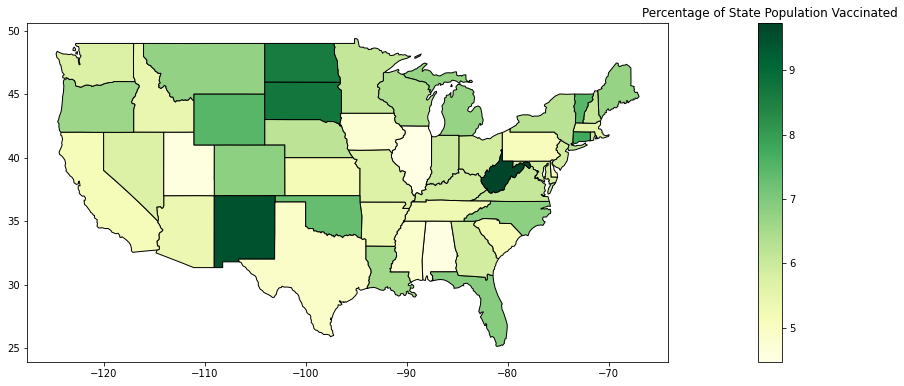

In [8]:
#importing necessary packages and data:
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world.name == 'United States of America']
states = gpd.read_file('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json')

#merging datasets to be used for map:
contiguous = states[(states.name != 'Alaska') & (states.name != 'Hawaii') & (states.name != 'Puerto Rico')]
merged_states = contiguous.merge(state_vax_pct, left_on='name', right_on='state')
merged_states = merged_states.drop(columns=['state', 'lat', 'long'])

#plotting choropleth map:
fig, ax = plt.subplots(figsize=(15, 15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)
merged_states.plot(column='percent_vaccinated', ax=ax, legend=True, cax=cax, cmap='YlGn', edgecolor='black')
plt.title('Percentage of State Population Vaccinated')

### Initial vaccine dose distribution
The following cell contains another choropleth map, this one showcasing the percentage of the population which has recieved an initial vaccine dose (as opposed to being fully vaccinated). Both the Pfizer and Moderna Covid vaccines require 2 doses for a patient to be fully vaccinated; so far the percentage of people who have recieved the initial dose is noticeably higher than the percentage of people who have been fully vaccinated.

Text(0.5, 1.0, 'Percentage who received Dose')

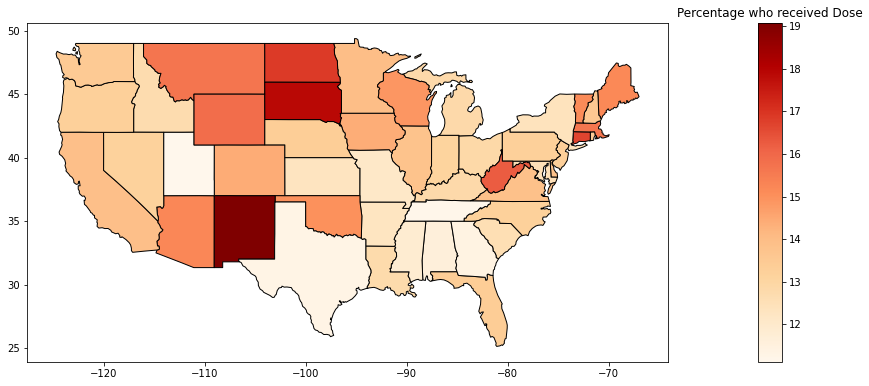

In [16]:
#state vaccination distribution rate choropleth:
state_dose_pct = state_vaccine_data[['state', 'percent_rcvd_dose']]
merged_doses = contiguous.merge(state_dose_pct, left_on='name', right_on='state')

#plotting second map:
fig2, ax2 = plt.subplots(figsize=(15, 15))
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='3%', pad=0.1)
merged_doses.plot(column='percent_rcvd_dose', ax=ax2, cax=cax2, legend=True, cmap='OrRd', edgecolor='black')
plt.title('Percentage who received Dose')

For the most part, states which displayed higher fully vaccinated percentages also display high distribution percentages, and states with low fully vaccinated percentages display low distribution percentages. However, some states of note (Georgia, Louisiana) show relatively low distribution percentages but relatively high full vaccination percentages indicating that most people who recieve the initial dose get fully vaccinated. Likewise, other states (Iowa, Illinois) show the opposite; high distribution rates but relatively low full vaccination rates, indicating that many initial doses have been distributed, but fewer have been fully vaccinated.